<a href="https://colab.research.google.com/github/lucamachado49/feedforward-neuralnet/blob/main/TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Classificação de Texto usando Redes Neurais

O objetivo de usar uma rede neural para classificação de texto é construir um modelo que possa aprender a interpretar, analisar e classificar textos em categorias predefinidas, de forma automatizada e precisa. Este processo envolve a extração de padrões e relações semânticas dos dados textuais, permitindo ao modelo tomar decisões baseadas nas características do texto.

Por que usar redes neurais em classificação de texto?
Redes neurais são utilizadas porque podem lidar com a complexidade e variabilidade do texto natural, como:

Ambiguidade de palavras (contexto importa).
Relações entre palavras em diferentes posições (dependências de longo alcance).
Análise de nuances, sentimentos ou intencionalidades.

### Projeto

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset=["description", "points"])

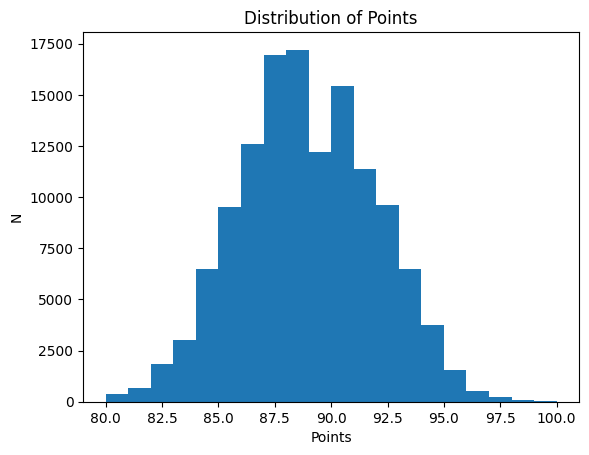

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Distribution of Points")
plt.xlabel("Points")
plt.ylabel("N")
plt.show()

In [ ]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "points", "label"]]

df.tail()

,description,points,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,1
129967,Citation is given as much as a decade of bottl...,90,1
129968,Well-drained gravel soil gives this wine its c...,90,1
129969,"A dry style of Pinot Gris, this is crisp with ...",90,1
129970,"Big, rich and off-dry, this is powered by inte...",90,1


In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [ ]:
def df_to_dataset(dataframe,shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.40109617, -0.42928705, -0.13768084, ...,  0.20079601,
         0.10275872, -0.03315512],
       [ 0.3738182 , -0.16600934, -0.07001656, ..., -0.1506141 ,
        -0.24193263,  0.2013167 ],
       [ 0.47903758, -0.35871252,  0.06139572, ..., -0.14409961,
        -0.23059781, -0.00345311],
       ...,
       [ 0.30247217, -0.24159695,  0.06717744, ...,  0.05847801,
        -0.2557902 ,  0.15307873],
       [ 0.47461578, -0.1050589 ,  0.09503344, ...,  0.10439311,
        -0.04340374, -0.23580901],
       [ 0.32878616, -0.3566419 ,  0.05904602, ...,  0.01514087,
        -0.22359987,  0.02351351]], dtype=float32)>

In [ ]:
# Wrap the hub_layer call in a custom Keras Layer
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_layer):
        super(HubLayerWrapper, self).__init__()
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)

# Criando um modelo funcional
inputs = tf.keras.Input(shape=(), dtype=tf.string)  # Entrada de texto
x = HubLayerWrapper(hub_layer)(inputs)  # Using the wrapper layer
x = tf.keras.layers.Dense(16, activation='relu')(x)  # Primeira camada densa
x = tf.keras.layers.Dropout(0.4)(x)  # Camada Dropout para regularização
x = tf.keras.layers.Dense(16, activation='relu')(x)  # Segunda camada densa
x = tf.keras.layers.Dropout(0.4)(x)  # Camada Dropout
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Camada de saída para classificação binária

# Construindo o modelo funcional
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compilando o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3772 - loss: 0.7262


[0.7262877821922302, 0.3775775134563446]

In [ ]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3878 - loss: 0.7243


[0.7246936559677124, 0.3856274485588074]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5396 - loss: 0.6929 - val_accuracy: 0.6218 - val_loss: 0.6520
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6344 - loss: 0.6514 - val_accuracy: 0.6477 - val_loss: 0.6276
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6444 - loss: 0.6341 - val_accuracy: 0.6737 - val_loss: 0.6062
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6643 - loss: 0.6137 - val_accuracy: 0.6828 - val_loss: 0.5931
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6737 - loss: 0.6044 - val_accuracy: 0.6888 - val_loss: 0.5861


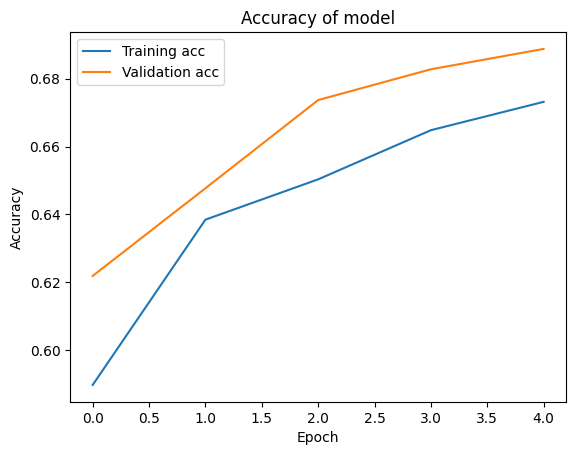

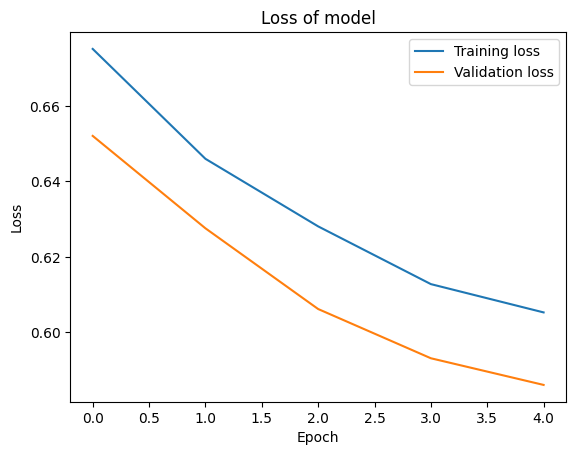

In [ ]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6997 - loss: 0.5819


[0.5826253294944763, 0.6972610950469971]

### LSTM


In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.4946 - loss: 0.6931
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.4974 - loss: 0.6931


[0.693091630935669, 0.49757635593414307]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 407ms/step - accuracy: 0.6578 - loss: 0.6158 - val_accuracy: 0.8168 - val_loss: 0.3939
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 402ms/step - accuracy: 0.8302 - loss: 0.3779 - val_accuracy: 0.8350 - val_loss: 0.3645
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.8424 - loss: 0.3510 - val_accuracy: 0.8369 - val_loss: 0.3497
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 83s 416ms/step - accuracy: 0.8494 - loss: 0.3362 - val_accuracy: 0.8407 - val_loss: 0.3451
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 421ms/step - accuracy: 0.8508 - loss: 0.3363 - val_accuracy: 0.8396 - val_loss: 0.3488


In [ ]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.8346 - loss: 0.3593


[0.35081952810287476, 0.8405908346176147]